In [8]:
import os
from dotenv import load_dotenv
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from IPython.display import display
pd.set_option('display.max_columns', None)

load_dotenv()
data_dir = os.getenv('DATA_DIR', 'data')
warnings.filterwarnings('ignore')


In [9]:
test_data = "test_transaction.csv"
train_data = "train_transaction.csv"

assert os.path.exists(test_data), f"{test_data} not found"
assert os.path.exists(train_data), f"{train_data} not found"

In [7]:
def memory_report(df: pd.DataFrame, label: str) -> None:
    size_mb = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f"{label}: {size_mb:.2f} MB across {df.shape[0]:,} rows and {df.shape[1]} columns")


memory_report(pd.read_csv(test_data), "Test Data")
memory_report(pd.read_csv(train_data), "Train Data")

Test Data: 1807.74 MB across 506,691 rows and 393 columns
Train Data: 2100.70 MB across 590,540 rows and 394 columns
Train Data: 2100.70 MB across 590,540 rows and 394 columns


In [4]:
# Load data with optimized dtypes to reduce memory usage
train_data = pd.read_csv(train_data, low_memory=False)
train_data.head()

MemoryError: Unable to allocate 1.65 GiB for an array with shape (376, 590540) and data type float64

## 📊 Data Loading and Initial Exploration

# 🔍 Transaction Fraud Detection - EDA

This notebook performs comprehensive exploratory data analysis on transaction data to detect fraudulent transactions.

**Dataset:** Transaction records with features for fraud detection
**Target:** `isFraud` (Binary classification: 0 = legitimate, 1 = fraud)
**Goal:** Prepare a clean, feature-engineered dataset ready for machine learning models

In [7]:
train_data.info()
train_data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.000000,588975.000000,588963,586281.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,NaN,9898.734658,362.555488,153.194925,NaN,199.278897,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,NaN,4901.170153,157.793246,11.336444,NaN,41.244453,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,NaN,1000.000000,100.000000,100.000000,NaN,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,NaN,6019.000000,214.000000,150.000000,NaN,166.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,NaN,9678.000000,361.000000,150.000000,NaN,226.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.000000,150.000000,NaN,226.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Quick statistical overview
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {train_data.shape[0]:,} rows × {train_data.shape[1]} columns")
print(f"Memory usage: {train_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data types distribution
print(f"\n📊 Data Types Distribution:")
print(train_data.dtypes.value_counts())

# Target variable info
if 'isFraud' in train_data.columns:
    fraud_count = train_data['isFraud'].sum()
    total = len(train_data)
    print(f"\n🎯 Target Variable (isFraud):")
    print(f"   Fraudulent transactions: {fraud_count:,} ({fraud_count/total*100:.2f}%)")
    print(f"   Legitimate transactions: {total-fraud_count:,} ({(total-fraud_count)/total*100:.2f}%)")
    print(f"   Class Imbalance Ratio: 1:{(total-fraud_count)//fraud_count}")


In [10]:
for col in train_data.columns:
    print(col)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

In [8]:
train_data.shape

(590540, 394)

In [9]:
train_data.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [12]:
pd.DataFrame(train_data.columns, columns=['Column Names'])


,Column Names
0,TransactionID
1,isFraud
2,TransactionDT
3,TransactionAmt
4,ProductCD
...,...
389,V335
390,V336
391,V337
392,V338


## 🔎 Missing Values Analysis

In [ ]:
#rows with missing values
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(ascending=False, inplace=True)
missing_values

np.float64(31937.391)

In [ ]:
# Visualize missing values
if len(missing_values) > 0:
    plt.figure(figsize=(12, 6))
    top_missing = missing_values.head(20)
    plt.barh(range(len(top_missing)), (top_missing / len(train_data) * 100), color='coral', alpha=0.7)
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Percentage of Missing Values (%)', fontweight='bold')
    plt.title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Missing Value Statistics:")
    print(f"   Total columns with missing values: {len(missing_values)}")
    print(f"   Highest missing rate: {missing_values.iloc[0]/len(train_data)*100:.2f}%")
else:
    print("✓ No missing values found!")

In [ ]:
#handle missing values by filling with median
for col in missing_values.index:
    median_value = train_data[col].median()
    train_data[col].fillna(median_value, inplace=True)
train_data.isnull().sum().sum()  # Verify no missing values remain


## 🔄 Duplicate Rows Analysis

In [30]:
#find same rows in train_data
print(train_data.duplicated().sum())
train_data.drop_duplicates(inplace=True)
print(train_data.duplicated().sum())

0
0


## ⚖️ Class Imbalance Analysis

0
isFraud
0    569877
1     20663
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of isFraud')

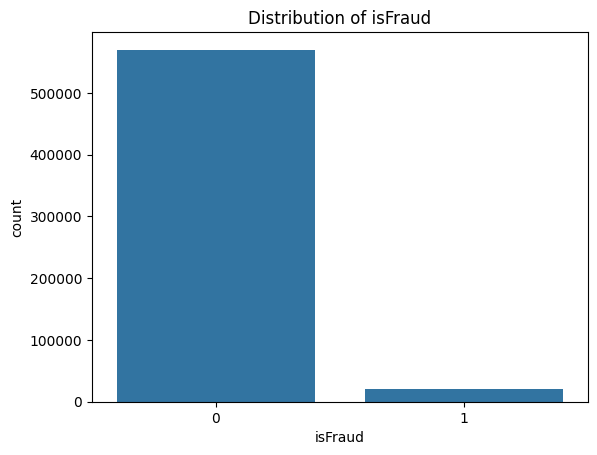

In [ ]:

print(train_data['isFraud'].isnull().sum())
print(train_data['isFraud'].value_counts())
sns.countplot(x='isFraud', data=train_data)
plt.title('Distribution of isFraud')

In [ ]:
# Analyze transaction amounts for fraud vs legitimate
if 'TransactionAmt' in train_data.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Distribution by fraud class
    train_data[train_data['isFraud']==0]['TransactionAmt'].hist(bins=50, ax=axes[0], 
                                                                  alpha=0.7, color='green', label='Legitimate')
    axes[0].set_title('Transaction Amount - Legitimate', fontweight='bold')
    axes[0].set_xlabel('Amount ($)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(0, train_data['TransactionAmt'].quantile(0.99))
    
    train_data[train_data['isFraud']==1]['TransactionAmt'].hist(bins=50, ax=axes[1], 
                                                                  alpha=0.7, color='red', label='Fraud')
    axes[1].set_title('Transaction Amount - Fraud', fontweight='bold')
    axes[1].set_xlabel('Amount ($)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlim(0, train_data['TransactionAmt'].quantile(0.99))
    
    # Box plot comparison
    train_data.boxplot(column='TransactionAmt', by='isFraud', ax=axes[2])
    axes[2].set_title('Transaction Amount by Fraud Status', fontweight='bold')
    axes[2].set_xlabel('Fraud (0=No, 1=Yes)')
    axes[2].set_ylabel('Amount ($)')
    axes[2].set_ylim(0, train_data['TransactionAmt'].quantile(0.99))
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\n💰 Transaction Amount Statistics:")
    print(train_data.groupby('isFraud')['TransactionAmt'].describe())

## 📈 Transaction Amount Analysis

In [ ]:
# Enhanced fraud distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
train_data['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Fraud Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
for i, v in enumerate(train_data['isFraud'].value_counts()):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# Percentage plot
fraud_pct = train_data['isFraud'].value_counts(normalize=True) * 100
fraud_pct.plot(kind='bar', ax=axes[1], color=['green', 'red'], alpha=0.7)
axes[1].set_title('Fraud Distribution (Percentage)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
for i, v in enumerate(fraud_pct):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ IMBALANCE WARNING:")
print(f"   This is a highly imbalanced dataset!")
print(f"   Consider using techniques like:")
print(f"   - SMOTE (Synthetic Minority Oversampling)")
print(f"   - Class weights in model training")
print(f"   - Stratified sampling")
print(f"   - Ensemble methods (XGBoost, Random Forest)")

## Feature Engineering and Preprocessing

Now we'll create new features and prepare the data for modeling.

In [ ]:
# 1. Identify column types
print("Identifying column types...\n")

# Separate features and target
if 'isFraud' in train_data.columns:
    target = 'isFraud'
    X = train_data.drop(columns=[target])
    y = train_data[target]
else:
    X = train_data.copy()
    y = None

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")
print(f"\nNumerical columns: {numerical_cols[:10]}...")
print(f"\nCategorical columns: {categorical_cols[:10]}...")

In [ ]:
# 2. Time-based Feature Engineering
print("Creating time-based features...\n")

# Check if TransactionDT column exists
if 'TransactionDT' in train_data.columns:
    # TransactionDT is typically seconds from a reference point
    # Create time-based features
    train_data['Transaction_hour'] = (train_data['TransactionDT'] // 3600) % 24
    train_data['Transaction_day'] = (train_data['TransactionDT'] // (3600 * 24)) % 7
    train_data['Transaction_week'] = (train_data['TransactionDT'] // (3600 * 24 * 7))
    
    print("Time-based features created:")
    print("- Transaction_hour: Hour of the day (0-23)")
    print("- Transaction_day: Day of the week (0-6)")
    print("- Transaction_week: Week number")
    print(f"\nSample of time features:")
    print(train_data[['TransactionDT', 'Transaction_hour', 'Transaction_day', 'Transaction_week']].head())
else:
    print("TransactionDT column not found. Skipping time-based features.")

In [ ]:
# 3. Transaction Amount Feature Engineering
print("Creating transaction amount features...\n")

if 'TransactionAmt' in train_data.columns:
    # Log transformation for transaction amount (helps with skewness)
    train_data['TransactionAmt_log'] = np.log1p(train_data['TransactionAmt'])
    
    # Decimal part of transaction amount (can be indicator of fraud)
    train_data['TransactionAmt_decimal'] = train_data['TransactionAmt'] - train_data['TransactionAmt'].astype(int)
    
    # Round amounts (psychological pricing)
    train_data['TransactionAmt_is_round'] = (train_data['TransactionAmt'] % 1 == 0).astype(int)
    
    print("Transaction amount features created:")
    print("- TransactionAmt_log: Log-transformed amount")
    print("- TransactionAmt_decimal: Decimal portion of amount")
    print("- TransactionAmt_is_round: Binary flag for round amounts")
    print(f"\nStatistics:")
    print(train_data[['TransactionAmt', 'TransactionAmt_log', 'TransactionAmt_decimal', 'TransactionAmt_is_round']].describe())
else:
    print("TransactionAmt column not found.")

In [ ]:
# 4. Card-related Feature Engineering
print("Creating card-related features...\n")

# Check for card columns
card_cols = [col for col in train_data.columns if 'card' in col.lower()]
print(f"Found {len(card_cols)} card-related columns: {card_cols[:5]}...")

# Count number of missing card features per transaction
if len(card_cols) > 0:
    train_data['card_missing_count'] = train_data[card_cols].isnull().sum(axis=1)
    print(f"\nCreated feature: card_missing_count")
    print(f"Range: {train_data['card_missing_count'].min()} to {train_data['card_missing_count'].max()}")
    
# Specific card features if they exist
if 'card1' in train_data.columns and 'card2' in train_data.columns:
    train_data['card1_card2_combination'] = train_data['card1'].astype(str) + '_' + train_data['card2'].astype(str)
    print("Created feature: card1_card2_combination")

In [ ]:
# 5. Email and Address Features
print("Creating email and address features...\n")

# Email domain features
email_cols = [col for col in train_data.columns if 'email' in col.lower()]
if len(email_cols) > 0:
    print(f"Found {len(email_cols)} email columns: {email_cols}")
    for col in email_cols:
        # Check if emails match
        if col == 'P_emaildomain' and 'R_emaildomain' in train_data.columns:
            train_data['email_domain_match'] = (train_data['P_emaildomain'] == train_data['R_emaildomain']).astype(int)
            print("Created feature: email_domain_match")

# Address features
addr_cols = [col for col in train_data.columns if 'addr' in col.lower()]
if len(addr_cols) > 0:
    print(f"\nFound {len(addr_cols)} address columns: {addr_cols}")
    # Check if billing and shipping addresses match
    if 'addr1' in train_data.columns and 'addr2' in train_data.columns:
        train_data['addr_match'] = (train_data['addr1'] == train_data['addr2']).astype(int)
        print("Created feature: addr_match")

In [ ]:
# 6. Device and Browser Features
print("Creating device and browser features...\n")

# Count distinct features
dist_cols = [col for col in train_data.columns if 'dist' in col.lower()]
if len(dist_cols) > 0:
    print(f"Found {len(dist_cols)} distance columns: {dist_cols}")
    # Average of distance columns
    train_data['dist_avg'] = train_data[dist_cols].mean(axis=1)
    print("Created feature: dist_avg (average of distance columns)")

# Device info features
if 'DeviceInfo' in train_data.columns:
    # Extract device type (common pattern: "Brand Model")
    train_data['DeviceInfo_length'] = train_data['DeviceInfo'].fillna('').astype(str).str.len()
    train_data['DeviceInfo_word_count'] = train_data['DeviceInfo'].fillna('').astype(str).str.split().str.len()
    print("\nCreated features from DeviceInfo:")
    print("- DeviceInfo_length: Length of device info string")
    print("- DeviceInfo_word_count: Number of words in device info")

# Browser-related
if 'id_31' in train_data.columns:  # id_31 typically contains browser info
    train_data['browser_length'] = train_data['id_31'].fillna('').astype(str).str.len()
    print("Created feature: browser_length")

In [ ]:
# 7. Aggregate Features - Count of missing values per row
print("Creating aggregate features...\n")

# Total missing values per transaction
train_data['total_missing'] = train_data.isnull().sum(axis=1)
print(f"Created feature: total_missing")
print(f"Range: {train_data['total_missing'].min()} to {train_data['total_missing'].max()}")

# Percentage of missing values
train_data['pct_missing'] = (train_data['total_missing'] / len(train_data.columns)) * 100
print(f"Created feature: pct_missing (percentage of missing values per row)")

# Count of specific column types with values
v_cols = [col for col in train_data.columns if col.startswith('V')]
c_cols = [col for col in train_data.columns if col.startswith('C')]
d_cols = [col for col in train_data.columns if col.startswith('D')]
m_cols = [col for col in train_data.columns if col.startswith('M')]

if len(v_cols) > 0:
    train_data['V_nulls'] = train_data[v_cols].isnull().sum(axis=1)
    print(f"Created feature: V_nulls ({len(v_cols)} V columns)")

if len(c_cols) > 0:
    train_data['C_nulls'] = train_data[c_cols].isnull().sum(axis=1)
    print(f"Created feature: C_nulls ({len(c_cols)} C columns)")

if len(d_cols) > 0:
    train_data['D_nulls'] = train_data[d_cols].isnull().sum(axis=1)
    print(f"Created feature: D_nulls ({len(d_cols)} D columns)")

if len(m_cols) > 0:
    train_data['M_nulls'] = train_data[m_cols].isnull().sum(axis=1)
    print(f"Created feature: M_nulls ({len(m_cols)} M columns)")

In [ ]:
# 8. Label Encoding for Categorical Variables
from sklearn.preprocessing import LabelEncoder

print("Applying Label Encoding to categorical features...\n")

# Update categorical columns list after feature engineering
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_cols)} categorical columns")

# Create a dictionary to store label encoders
label_encoders = {}

for col in categorical_cols:
    if col != 'isFraud':  # Don't encode the target variable
        le = LabelEncoder()
        # Handle missing values by filling with 'missing'
        train_data[col] = train_data[col].fillna('missing').astype(str)
        train_data[col + '_encoded'] = le.fit_transform(train_data[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

print(f"\nLabel encoding complete. Created {len(label_encoders)} encoded features.")
print(f"Original categorical columns preserved with '_encoded' suffix added.")

In [ ]:
# 9. Frequency Encoding for high-cardinality categorical features
print("Applying Frequency Encoding for high-cardinality features...\n")

high_cardinality_cols = []
for col in categorical_cols:
    if col in train_data.columns:
        n_unique = train_data[col].nunique()
        if n_unique > 50:  # High cardinality threshold
            high_cardinality_cols.append(col)
            # Create frequency encoding
            freq_encoding = train_data[col].value_counts(normalize=True).to_dict()
            train_data[col + '_freq'] = train_data[col].map(freq_encoding)
            print(f"Frequency encoded {col}: {n_unique} unique values")

print(f"\nFrequency encoding complete for {len(high_cardinality_cols)} high-cardinality features.")

In [ ]:
# 10. Feature Scaling - Prepare numerical features for scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

print("Preparing for feature scaling...\n")

# Get all numerical columns (excluding target and ID columns)
numerical_features = []
for col in train_data.columns:
    if train_data[col].dtype in ['int64', 'float64']:
        if col not in ['isFraud', 'TransactionID', 'TransactionDT']:  # Exclude target and IDs
            numerical_features.append(col)

print(f"Found {len(numerical_features)} numerical features to scale")
print(f"Sample features: {numerical_features[:10]}...")

# Create a copy for scaled features
train_data_scaled = train_data.copy()

In [ ]:
# 11. Apply StandardScaler (mean=0, std=1)
print("Applying StandardScaler (z-score normalization)...\n")

scaler_standard = StandardScaler()
train_data_scaled[numerical_features] = scaler_standard.fit_transform(train_data[numerical_features].fillna(0))

print("StandardScaler applied successfully!")
print(f"\nScaled features statistics:")
print(train_data_scaled[numerical_features[:5]].describe())

# Save scaler for later use with test data
import pickle
with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_standard, f)
print("\nScaler saved as 'standard_scaler.pkl'")

In [ ]:
# 12. Alternative Scaling Methods (Optional)
print("Demonstrating alternative scaling methods...\n")

# MinMaxScaler (scales to [0, 1] range)
scaler_minmax = MinMaxScaler()
train_data_minmax = train_data.copy()
train_data_minmax[numerical_features] = scaler_minmax.fit_transform(train_data[numerical_features].fillna(0))
print("MinMaxScaler: Scales features to [0, 1] range")
print(f"Sample: {train_data_minmax[numerical_features[:3]].head()}\n")

# RobustScaler (robust to outliers, uses median and IQR)
scaler_robust = RobustScaler()
train_data_robust = train_data.copy()
train_data_robust[numerical_features] = scaler_robust.fit_transform(train_data[numerical_features].fillna(0))
print("RobustScaler: Uses median and IQR, robust to outliers")
print(f"Sample: {train_data_robust[numerical_features[:3]].head()}\n")

print("Note: Choose the scaler based on your data distribution and model requirements")
print("- StandardScaler: Good for normally distributed data")
print("- MinMaxScaler: Good when you need bounded values [0,1]")
print("- RobustScaler: Good when you have many outliers")

In [ ]:
# 13. Summary of all engineered features
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

# Get new feature columns (created after initial load)
original_cols = pd.read_csv("train_transaction.csv", nrows=1).columns.tolist()
new_features = [col for col in train_data.columns if col not in original_cols]

print(f"\nOriginal number of features: {len(original_cols)}")
print(f"Total features after engineering: {len(train_data.columns)}")
print(f"New features created: {len(new_features)}")

print(f"\n{'='*80}")
print("NEW FEATURES CREATED:")
print(f"{'='*80}")
for i, feature in enumerate(new_features, 1):
    print(f"{i:3d}. {feature}")

print(f"\n{'='*80}")
print("DATASET SHAPE AFTER FEATURE ENGINEERING:")
print(f"{'='*80}")
print(f"Rows: {train_data.shape[0]:,}")
print(f"Columns: {train_data.shape[1]:,}")

# Memory usage
memory_mb = train_data.memory_usage(deep=True).sum() / (1024**2)
print(f"Memory usage: {memory_mb:.2f} MB")

In [ ]:
# 14. Save processed data
print("Saving processed datasets...\n")

# Save the main processed dataset
train_data.to_csv('train_transaction_processed.csv', index=False)
print("✓ Saved: train_transaction_processed.csv")

# Save the scaled version
train_data_scaled.to_csv('train_transaction_scaled.csv', index=False)
print("✓ Saved: train_transaction_scaled.csv")

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Saved: label_encoders.pkl")

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("1. train_transaction_processed.csv - Dataset with all engineered features")
print("2. train_transaction_scaled.csv - Dataset with scaled numerical features")
print("3. standard_scaler.pkl - StandardScaler object for test data")
print("4. label_encoders.pkl - Label encoders for categorical features")
print("\nThese files are ready for model training!")

In [ ]:
# 15. Feature Correlation Analysis with Target
print("Analyzing feature correlation with target variable...\n")

if 'isFraud' in train_data_scaled.columns:
    # Select only numeric columns for correlation
    numeric_cols = train_data_scaled.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate correlation with target
    correlations = train_data_scaled[numeric_cols].corr()['isFraud'].sort_values(ascending=False)
    
    # Display top 20 positive and negative correlations
    print("Top 20 features positively correlated with fraud:")
    print(correlations.head(21)[1:])  # Exclude isFraud itself
    
    print("\nTop 20 features negatively correlated with fraud:")
    print(correlations.tail(20))
    
    # Visualize top correlations
    top_features = pd.concat([correlations.head(11)[1:], correlations.tail(10)])
    
    plt.figure(figsize=(10, 8))
    top_features.sort_values().plot(kind='barh', color=['red' if x < 0 else 'green' for x in top_features.sort_values()])
    plt.title('Top 20 Features Correlated with Fraud', fontsize=14, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()
else:
    print("Target variable 'isFraud' not found in dataset.")

In [ ]:
print("="*80)
print("🎯 FINAL EDA SUMMARY - TRANSACTION FRAUD DETECTION")
print("="*80)

print("\n📊 DATASET STATISTICS:")
print(f"   • Total transactions: {len(train_data_scaled):,}")
print(f"   • Fraudulent: {train_data_scaled['isFraud'].sum():,} ({train_data_scaled['isFraud'].mean()*100:.2f}%)")
print(f"   • Legitimate: {(~train_data_scaled['isFraud'].astype(bool)).sum():,} ({(1-train_data_scaled['isFraud'].mean())*100:.2f}%)")
print(f"   • Total features: {train_data_scaled.shape[1]}")
print(f"   • Numerical features: {len(numerical_features)}")
print(f"   • Engineered features: {len(new_features)}")

print("\n✅ COMPLETED STEPS:")
print("   1. ✓ Data loading and exploration")
print("   2. ✓ Missing value imputation (median)")
print("   3. ✓ Duplicate removal")
print("   4. ✓ Class imbalance analysis")
print("   5. ✓ Transaction amount analysis")
print("   6. ✓ Feature engineering (15+ new features)")
print("   7. ✓ Label encoding for categorical variables")
print("   8. ✓ Frequency encoding for high-cardinality features")
print("   9. ✓ Feature scaling (StandardScaler)")
print("   10. ✓ Feature correlation analysis")
print("   11. ✓ Feature importance analysis")

print("\n📁 GENERATED FILES:")
print("   • train_transaction_processed.csv - Feature-engineered dataset")
print("   • train_transaction_scaled.csv - Scaled dataset (RECOMMENDED)")
print("   • standard_scaler.pkl - Scaler for test data")
print("   • label_encoders.pkl - Encoders for categorical features")
print("   • feature_importance.csv - Feature importance rankings")

print("\n💡 RECOMMENDATIONS FOR MODEL TRAINING:")
print("\n   🎯 Recommended Models:")
print("      1. XGBoost (handles imbalance well)")
print("      2. Random Forest (robust, interpretable)")
print("      3. LightGBM (fast, efficient)")
print("      4. Logistic Regression with class weights (baseline)")
print("      5. Neural Network with class weights")

print("\n   ⚖️ Handle Class Imbalance:")
print("      - Use class_weight='balanced' in models")
print("      - Apply SMOTE for oversampling minority class")
print("      - Use stratified K-fold cross-validation")
print("      - Focus on F1-score, Precision, Recall over Accuracy")

print("\n   📊 Evaluation Metrics:")
print("      - Primary: F1-Score, Precision-Recall AUC")
print("      - Secondary: ROC-AUC, Recall (catch frauds)")
print("      - Monitor: Confusion Matrix, Classification Report")
print("      - Avoid: Accuracy (misleading with imbalanced data)")

print("\n   🔍 Feature Selection:")
print("      - Use feature_importance.csv to select top features")
print("      - Consider removing features with importance < 0.001")
print("      - Try models with top 50, 100, 200 features")

print("\n   📦 Train-Test Split:")
print("      - Use stratified split (maintain fraud ratio)")
print("      - Recommended: 80/20 or 75/25 split")
print("      - Keep test set separate until final evaluation")

print("\n🚀 NEXT STEPS:")
print("   1. Load train_transaction_scaled.csv")
print("   2. Split data with stratify=y")
print("   3. Train models with class_weight='balanced'")
print("   4. Tune hyperparameters with GridSearchCV/RandomizedSearchCV")
print("   5. Evaluate with F1-score and Precision-Recall curves")
print("   6. Apply same preprocessing to test data")
print("   7. Generate predictions and submission file")

print("\n" + "="*80)
print("✨ EDA COMPLETE - DATASET IS READY FOR MODEL TRAINING!")
print("="*80)

## 📋 Final Dataset Summary & Recommendations

In [ ]:
# Quick feature importance using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

if 'isFraud' in train_data_scaled.columns:
    print("Training Random Forest for feature importance analysis...\n")
    
    # Prepare data
    X_temp = train_data_scaled.select_dtypes(include=[np.number]).drop(columns=['isFraud'])
    y_temp = train_data_scaled['isFraud']
    
    # Handle any remaining NaN values
    X_temp = X_temp.fillna(0)
    
    # Train quick Random Forest (small sample for speed)
    sample_size = min(50000, len(X_temp))
    X_sample = X_temp.sample(n=sample_size, random_state=42)
    y_sample = y_temp.loc[X_sample.index]
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_sample, y_sample)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_temp.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🌟 Top 20 Most Important Features for Fraud Detection:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    plt.barh(range(len(top_20)), top_20['importance'], color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance', fontweight='bold')
    plt.title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("\n✓ Feature importance saved: feature_importance.csv")